In [227]:
%reset

In [228]:
import tensorflow as tf
from tensorflow import newaxis
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt

In [229]:
from sionna.phy.utils import ebnodb2no, PlotBER
from sionna.phy.mapping import Constellation, Mapper, BinarySource, Demapper
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.channel.tr38901 import TDL
from sionna.phy.channel.utils import cir_to_time_channel, time_lag_discrete_time_channel, time_to_ofdm_channel
from sionna.phy.channel import ApplyTimeChannel, AWGN
from tensorflow.signal import ifftshift
from sionna.phy.signal import ifft
from sionna.phy.ofdm import ResourceGrid, OFDMDemodulator, ResourceGridMapper, OFDMModulator, LMMSEEqualizer
from sionna.phy.mimo import StreamManagement


In [247]:
sim_esno = False
num_bits_per_symbol = 2
ebno_db = 10 # np.arange(0, 16, 2)
uncoded = False
n = 128 # desired codeword length
k = 64  # number of information bits per codeword
source = BinarySource()
batch_size = 100
channel_model = "tdl"
delay_spread = 100e-9  # Sionna recommends this delay spread. lmin and
                       # lmax from the function are associated with this.
tdl = TDL(model="C",
          delay_spread = delay_spread,
          carrier_frequency = 3.5e9,
          min_speed = 0,
          max_speed = 0,)

In [248]:
constellation = Constellation("qam",num_bits_per_symbol = num_bits_per_symbol)
mapper = Mapper(constellation = constellation)
encoder = LDPC5GEncoder(k=k, n=n)
decoder = LDPC5GDecoder(encoder, num_iter=40)

In [249]:
block_size = 64
block_per_frame = n//num_bits_per_symbol//block_size
cp_length = 6 # to 16
frame_size = int((block_size+cp_length)*block_per_frame)

In [250]:
bandwidth = 2e6 # 2/4/8/16 MHz
subcarrier_spacing = bandwidth / (block_per_frame*block_size) # e.g., 15 kHz for 2 MHz bandwidth

In [251]:

l_min, l_max = time_lag_discrete_time_channel(bandwidth,3e-06)
l_tot = int(l_max - l_min + 1)


In [252]:
l_min

<tf.Tensor: shape=(), dtype=int32, numpy=-6>

In [253]:
_apply_channel = ApplyTimeChannel(frame_size,
                                       l_tot,
                                       precision='double')

In [254]:
channel_noise = AWGN()

In [255]:
num_time_steps = frame_size + l_tot - 1

In [256]:
rg = ResourceGrid(num_ofdm_symbols=1,
                  fft_size=int(block_size),
                  subcarrier_spacing=subcarrier_spacing,
                  cyclic_prefix_length=cp_length,
                  pilot_pattern='empty')

demodulator_ofdm = OFDMDemodulator(rg.fft_size, l_min, rg.cyclic_prefix_length)
demapper = Demapper("app", constellation=constellation)

### Building OFDM class

In [273]:
class OFDM_System(Model):
    def __init__(self, batch_size, fec_k , fec_n, bits_per_symbol):
        super().__init__()

        self.num_bits_per_symbol = bits_per_symbol
        self.uncoded = False
        self.n = fec_n # desired codeword length
        self.k = fec_k  # number of information bits per codeword
        self.source = BinarySource()
        self.batch_size = batch_size
        delay_spread = 100e-9  # Sionna recommends this delay spread. lmin and
                               # lmax from the function are associated with this.
        self.tdl = TDL(model="C",
                  delay_spread = delay_spread,
                  carrier_frequency = 3.5e9,
                  min_speed = 0,
                  max_speed = 0)

        constellation = Constellation("qam",num_bits_per_symbol = self.num_bits_per_symbol)
        self.block_size = 64
        self.block_per_frame = self.n//self.num_bits_per_symbol//self.block_size
        self.cp_length = 6 # to 16
        self.bandwidth = 2e6 # 2/4/8/16 MHz
        subcarrier_spacing = self.bandwidth / (self.block_per_frame*self.block_size)
        self.mapper = Mapper(constellation = constellation)
        self.encoder = LDPC5GEncoder(k=self.k, n=self.n)
        self.rg = ResourceGrid(num_ofdm_symbols=self.block_per_frame,
                                       fft_size=int(self.block_size),
                                       subcarrier_spacing=subcarrier_spacing,
                                       cyclic_prefix_length=self.cp_length,
                                       pilot_pattern='empty')

        self.rg_mapper = ResourceGridMapper(self.rg)
        self.modulator_ofdm = OFDMModulator(self.cp_length)
        self.decoder = LDPC5GDecoder(self.encoder, num_iter=40)


        self.frame_size = int((self.block_size+self.cp_length)*self.block_per_frame)

        #
        self.l_min, self.l_max = time_lag_discrete_time_channel(self.bandwidth,3e-06)
        l_tot = int(self.l_max - self.l_min + 1)
        self._apply_channel = ApplyTimeChannel(self.frame_size,
                                               l_tot,
                                               precision='double')
        self.channel_noise = AWGN()
        self.num_time_steps = self.frame_size + l_tot - 1
        sm = StreamManagement(np.array([[1]]), 1)
        self.lmmse_equ = LMMSEEqualizer(self.rg, sm) # ZFEqualizer, LMMSEEqualizer
        self.demodulator_ofdm = OFDMDemodulator(self.rg.fft_size, self.l_min, self.rg.cyclic_prefix_length)
        self.demapper = Demapper("app", constellation=constellation)

    @tf.function
    def call(self, batch_size, ebno_db):
        # Transmitter
        coderate = 1.0 if self.uncoded else self.k/self.n
        no = ebnodb2no(ebno_db,
                       num_bits_per_symbol=self.num_bits_per_symbol,
                       coderate=coderate)
        # generate information bits
        u = self.source([batch_size, self.k])
        if self.uncoded:
            c = u
        else:
            c = self.encoder(u) # encode
        s = self.mapper(c) # map bits to symbols

        x_rg = self.rg_mapper(s[..., newaxis, newaxis, :])
        s_frame = self.modulator_ofdm(x_rg)


        a, tau = self.tdl(batch_size,  self.num_time_steps, self.bandwidth)
        h_time = cir_to_time_channel(self.bandwidth, a, tau, self.l_min, self.l_max, True)
        y_c = self._apply_channel(s_frame, h_time)
        y_c_noise = self.channel_noise(y_c, no)

        # Receiver
        # Compute channel in frequency domain
        h_freq = time_to_ofdm_channel(h_time,self.rg, self.l_min)
        # FFT is present inside the demodulator
        Y = self.demodulator_ofdm(y_c_noise)
        # print(Y.shape)
        err_var = 0.
        x_hat, no_eff =  self.lmmse_equ(Y, h_freq, err_var, no)
        # print(x_hat.shape)
        llr_ch =  self.demapper(x_hat, no_eff)

        if self.uncoded:
            u_hat = tf.squeeze(tf.cast(llr_ch > 0, tf.float32))
        else:
            u_hat = tf.squeeze(self.decoder(llr_ch))
        # if self.cw_estimates:
        #     return c, u_hat
        return u, u_hat


### Building SC-FDE class

In [290]:
class SC_FDE_System(Model):
    def __init__(self, batch_size, fec_k , fec_n, bits_per_symbol):
        super().__init__()

        self.num_bits_per_symbol = bits_per_symbol
        self.uncoded = False
        self.n = fec_n # desired codeword length
        self.k = fec_k  # number of information bits per codeword
        self.source = BinarySource()
        self.batch_size = batch_size

        delay_spread = 100e-9  # Sionna recommends this delay spread. lmin and
                               # lmax from the function are associated with this.
        self.tdl = TDL(model="C",
                  delay_spread = delay_spread,
                  carrier_frequency = 3.5e9,
                  min_speed = 0,
                  max_speed = 0,)

        constellation = Constellation("qam",num_bits_per_symbol = self.num_bits_per_symbol)
        self.mapper = Mapper(constellation = constellation)
        self.encoder = LDPC5GEncoder(k=self.k, n=self.n)
        self.decoder = LDPC5GDecoder(self.encoder, num_iter=40)

        self.block_size = 64
        self.block_per_frame = self.n//self.num_bits_per_symbol//self.block_size
        self.cp_length = 6 # to 16
        self.frame_size = int((self.block_size+self.cp_length)*self.block_per_frame)

        self.bandwidth = 2e6 # 2/4/8/16 MHz
        # subcarrier_spacing = self.bandwidth / (self.block_per_frame*self.block_size) # e.g., 15 kHz for 2 MHz bandwidth

        self.l_min, self.l_max = time_lag_discrete_time_channel(self.bandwidth,3e-06)
        l_tot = int(self.l_max - self.l_min + 1)
        self._apply_channel = ApplyTimeChannel(self.frame_size,
                                               l_tot,
                                               precision='double')
        self.channel_noise = AWGN()
        self.num_time_steps = self.frame_size + l_tot - 1

        self.demodulator_ofdm = OFDMDemodulator(int(self.block_size), self.l_min, self.cp_length)
        self.demapper = Demapper("app", constellation=constellation)

    @tf.function
    def call(self, batch_size, ebno_db):
        # Transmitter
        coderate = 1.0 if self.uncoded else self.k/self.n
        no = ebnodb2no(ebno_db,
                       num_bits_per_symbol=self.num_bits_per_symbol,
                       coderate=coderate)
        # generate information bits
        u = self.source([batch_size, self.k])
        if self.uncoded:
            c = u
        else:
            c = self.encoder(u) # encode
        s = self.mapper(c) # map bits to symbols
        s_cp = tf.reshape(s, [batch_size, self.block_per_frame, self.block_size])
        cp = s_cp[...,s_cp.shape[-1]- self.cp_length:]
        signal_with_cp = tf.concat([cp, s_cp], axis=-1)
        s_frame = tf.reshape(signal_with_cp, [batch_size, 1, 1, self.frame_size])
        a, tau = self.tdl(batch_size,  self.num_time_steps, self.bandwidth)
        h_time = cir_to_time_channel(self.bandwidth, a, tau, self.l_min, self.l_max, True)
        y_c = self._apply_channel(s_frame, h_time)
        y_c_noise = self.channel_noise(y_c, no)

        # Receiver
        # Compute channel in frequency domain
        # print(h_time.shape)
        h_freq = self._channel_time_to_freq(h_time, self.l_min)

        # print(h_freq.shape)

        # FFT is present inside the demodulator
        Y = self.demodulator_ofdm(y_c_noise)
        X_hat, no_eff = self._equalizer_fde(Y, h_freq, no, self.block_size, batch_size)
        # print(no_eff.shape)
        x_freq = ifftshift(X_hat, axes=-1)
        # Compute IFFT along the last dimension
        s_hat =  ifft(x_freq)
        s_hat = tf.reshape(s_hat, [batch_size, 1, 1, self.block_size*self.block_per_frame])
        llr_ch =  self.demapper(s_hat, no_eff)

        if self.uncoded:
            u_hat = tf.squeeze(tf.cast(llr_ch > 0, tf.float32))
        else:
            u_hat = tf.squeeze(self.decoder(llr_ch))
        # if self.cw_estimates:
        #     return c, u_hat
        return u, u_hat


    def _equalizer_fde(self, Y, h_freq, no, block_size, batch_size):

        h_diagonal = tf.squeeze(tf.linalg.diag(h_freq), axis=[1, 2, 3, 4])
        H_H = tf.linalg.adjoint(h_diagonal)
        HH_H = tf.matmul(H_H, h_diagonal)
        gamma = tf.complex(1.0 / no, 0.0)
        N = tf.shape(HH_H)[-1]
        I = tf.eye(N, dtype=h_diagonal.dtype)
        regularized = HH_H + tf.expand_dims((1.0 / gamma) * I, axis=0)
        regularized_inv = tf.linalg.inv(regularized)
        C = tf.matmul(H_H, regularized_inv)
        C_H = tf.linalg.adjoint(C)
        C_CH = tf.matmul(C, C_H)
        no_eff = tf.math.real(tf.linalg.diag_part(tf.complex(no, 0.0) * C_CH))
        # no_eff = tf.math.real(
        #     tf.linalg.trace(tf.complex(no, 0.0) * C_CH) / block_size
        # )
        # no_eff = tf.broadcast_to(
        #     no_eff[:, :, None],
        #     [batch_size, self.block_per_frame, block_size]
        # )
        no_eff = tf.reshape(no_eff, [batch_size, 1, 1, self.block_per_frame*block_size])
        Y_sq = tf.squeeze(Y, axis=[1, 2])
        Y_sq = Y_sq[..., None]
        X_hat_unsq = tf.matmul(C, Y_sq)
        X_hat_unsq = tf.squeeze(X_hat_unsq, axis=-1)
        X_hat = tf.reshape(X_hat_unsq, [batch_size, 1, 1, self.block_per_frame, block_size])

        return X_hat, no_eff

    def _channel_time_to_freq(self, h_t, l_min):
        fft_size = self.block_size
        ofdm_length = self.block_size + self.cp_length
        h_t = h_t[..., self.cp_length:self.frame_size:ofdm_length, :]

        # Pad channel impulse response with zeros to the FFT size
        pad_dims = fft_size - tf.shape(h_t)[-1]
        pad_shape = tf.concat([tf.shape(h_t)[:-1], [pad_dims]], axis=-1)
        h_t = tf.concat([h_t, tf.zeros(pad_shape, dtype=h_t.dtype)], axis=-1)

        # starts with h_{b,0}
        h_t = tf.roll(h_t, l_min, axis=-1)
        # Compute FFT
        h_f = tf.signal.fft(h_t)
        # Move the zero subcarrier to the center of the spectrum
        h_f = tf.signal.fftshift(h_f, axes=-1)

        return h_f

In [300]:
batch_size = 100
fec_k = 512
fec_n = 1024
bits_per_sample = 2
scfdesys = SC_FDE_System(batch_size,fec_k,fec_n, bits_per_sample)
ofdmsys = OFDM_System(batch_size,fec_k,fec_n, bits_per_sample)
ebno_db = 10#np.arange(0, 16, 2)
u_,u_hat_ = scfdesys(tf.constant(batch_size, tf.int32), tf.constant(ebno_db, tf.float32))

In [301]:
tf.reduce_sum(tf.abs(u_-u_hat_)).numpy()

0.0

In [302]:
ber_plot_bicm = PlotBER("BER Performance")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.4160e-01 | 1.0000e+00 |       12370 |       51200 |          100 |         100 |         0.1 |reached target bit errors
      1.0 | 1.7418e-01 | 8.8500e-01 |       17836 |      102400 |          177 |         200 |         0.1 |reached target bit errors
      2.0 | 4.9204e-02 | 2.6000e-01 |       10077 |      204800 |          104 |         400 |         0.3 |reached target bit errors
      3.0 | 2.5144e-02 | 1.2625e-01 |       10299 |      409600 |          101 |         800 |         0.5 |reached target bit errors
      4.0 | 1.0319e-02 | 5.0526e-02 |       10038 |      972800 |           96 |        1900 |         1.2 |reached target bit errors
      5.0 | 5.3948e-03 | 2.6757e-02 |       10220 |     1894400 |          

(<tf.Tensor: shape=(14,), dtype=float32, numpy=
 array([ 1.9587891e-01,  8.2675785e-02,  2.2606337e-02,  6.3419859e-03,
         2.4501954e-03,  1.0213933e-03,  4.9414061e-04,  3.0693359e-04,
         1.5751953e-04,  1.2031250e-04,  2.9394530e-05,  0.0000000e+00,
        -1.0000000e+00, -1.0000000e+00], dtype=float32)>,
 <tf.Tensor: shape=(14,), dtype=float32, numpy=
 array([ 1.0000000e+00,  5.6666666e-01,  1.3555555e-01,  3.8387097e-02,
         1.3375000e-02,  5.7512955e-03,  2.8500000e-03,  1.8000000e-03,
         8.5000001e-04,  6.0000003e-04,  1.5000001e-04,  0.0000000e+00,
        -1.0000000e+00, -1.0000000e+00], dtype=float32)>)

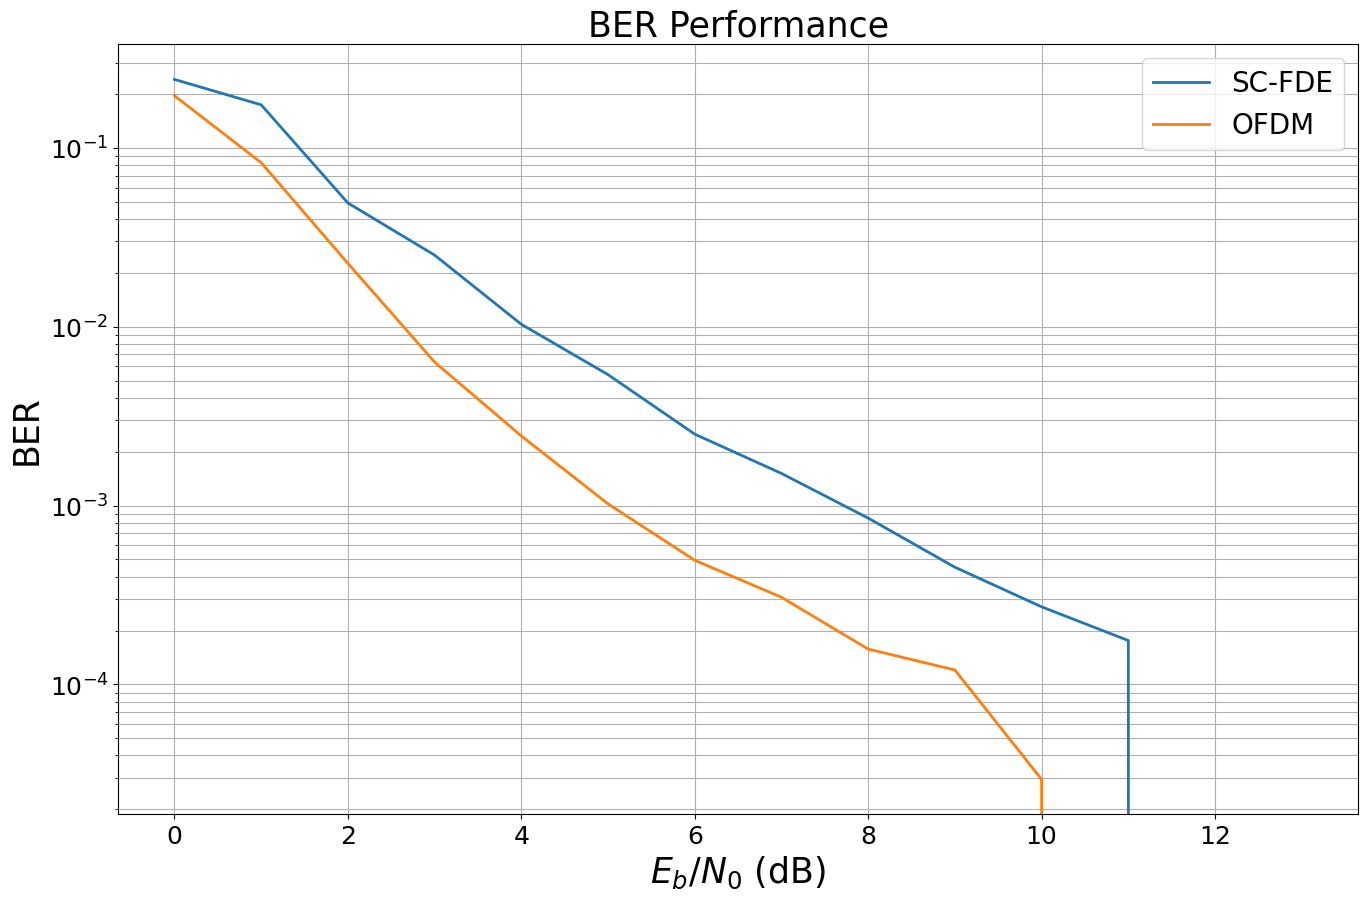

In [303]:
ber_plot_bicm.simulate(scfdesys, # the function have defined previously
                          ebno_dbs=np.arange(0, 14, 1),
                          legend="SC-FDE",
                          max_mc_iter=200,
                          num_target_bit_errors=10000,
                          batch_size=batch_size,
                          soft_estimates=False,
                          early_stop=True,
                          show_fig=False,
                          forward_keyboard_interrupt=False)

ber_plot_bicm.simulate(ofdmsys, # the function have defined previously
                          ebno_dbs=np.arange(0, 14, 1),
                          legend="OFDM",
                          max_mc_iter=200,
                          num_target_bit_errors=10000,
                          batch_size=batch_size,
                          soft_estimates=False,
                          early_stop=True,
                          show_fig=True,
                          forward_keyboard_interrupt=False)

### 20-BP (128,64) LDPC

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.2833e-01 | 9.0714e-01 |       10229 |       44800 |          635 |         700 |         0.8 |reached target bit errors
      1.0 | 1.6178e-01 | 7.0500e-01 |       10354 |       64000 |          705 |        1000 |         0.3 |reached target bit errors
      2.0 | 7.7173e-02 | 3.5714e-01 |       10372 |      134400 |          750 |        2100 |         0.6 |reached target bit errors
      3.0 | 3.3507e-02 | 1.5787e-01 |       10079 |      300800 |          742 |        4700 |         1.3 |reached target bit errors
      4.0 | 1.2089e-02 | 5.4308e-02 |       10058 |      832000 |          706 |       13000 |         3.6 |reached target bit errors
      5.0 | 5.6680e-03 | 2.5450e-02 |        7255 |     1280000 |          

(<tf.Tensor: shape=(14,), dtype=float32, numpy=
 array([1.96347654e-01, 1.24663465e-01, 5.67466505e-02, 2.12732255e-02,
        8.84710439e-03, 4.28124983e-03, 2.45078118e-03, 1.41875003e-03,
        9.30468726e-04, 4.32812492e-04, 3.50781251e-04, 1.87500002e-04,
        6.09374983e-05, 2.18749992e-05], dtype=float32)>,
 <tf.Tensor: shape=(14,), dtype=float32, numpy=
 array([9.13749993e-01, 6.13846183e-01, 2.94285715e-01, 1.05135135e-01,
        4.09039557e-02, 1.90999992e-02, 1.05999997e-02, 6.09999988e-03,
        3.55000002e-03, 1.75000005e-03, 1.44999998e-03, 7.50000007e-04,
        2.50000012e-04, 9.99999975e-05], dtype=float32)>)

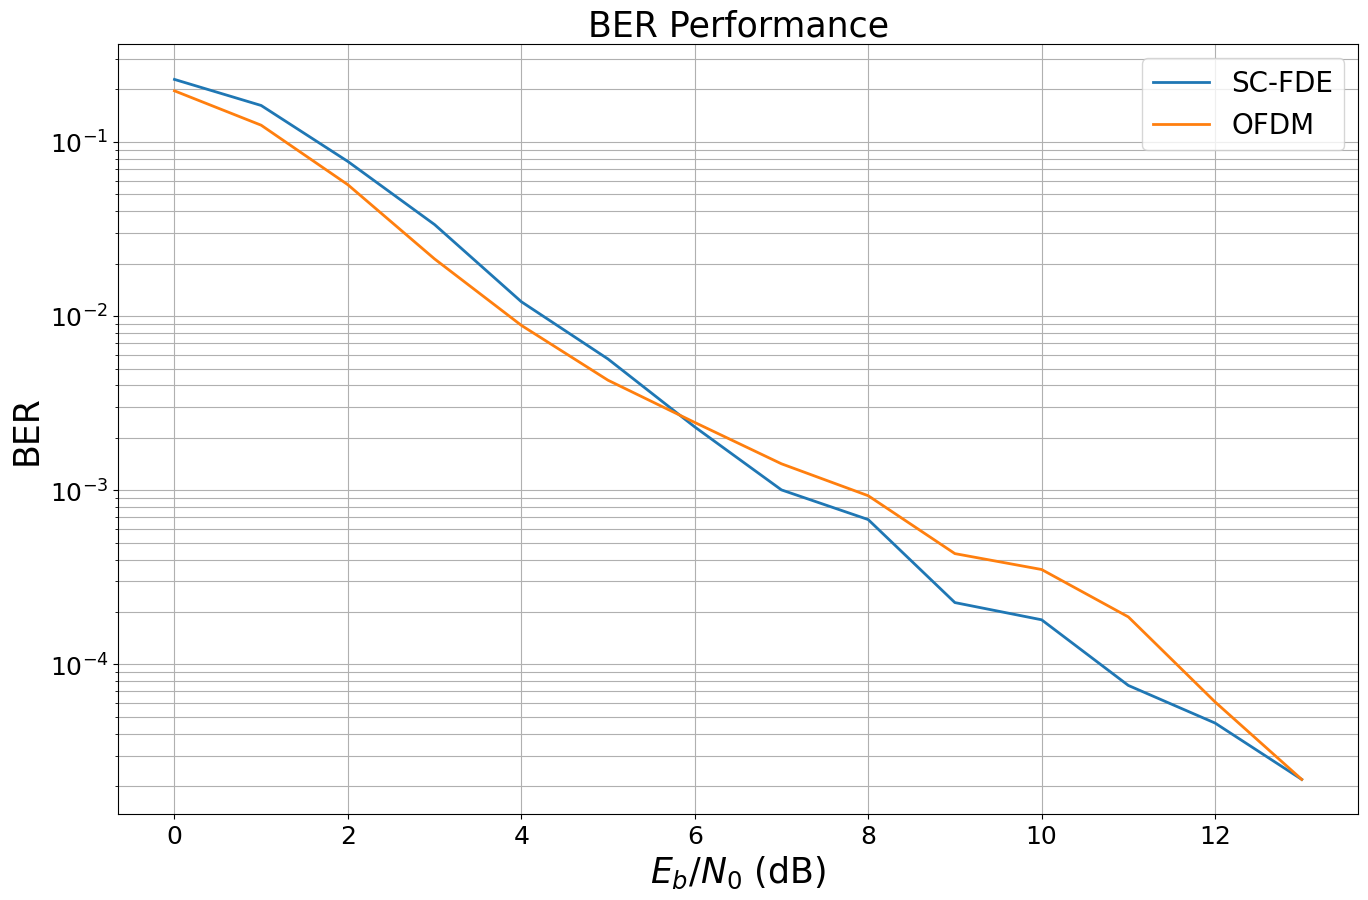

In [40]:
ber_plot_bicm.simulate(scfdesys, # the function have defined previously
                          ebno_dbs=np.arange(0, 14, 1),
                          legend="SC-FDE",
                          max_mc_iter=200,
                          num_target_bit_errors=10000,
                          batch_size=batch_size,
                          soft_estimates=False,
                          early_stop=True,
                          show_fig=False,
                          forward_keyboard_interrupt=False)

ber_plot_bicm.simulate(ofdmsys, # the function have defined previously
                          ebno_dbs=np.arange(0, 14, 1),
                          legend="OFDM",
                          max_mc_iter=200,
                          num_target_bit_errors=10000,
                          batch_size=batch_size,
                          soft_estimates=False,
                          early_stop=True,
                          show_fig=True,
                          forward_keyboard_interrupt=False)


### Transmitter

In [257]:

coderate = 1.0 if uncoded else k/n
no = ebnodb2no(ebno_db,
               num_bits_per_symbol=num_bits_per_symbol,
               coderate=coderate)
# generate information bits
u = source([batch_size, k])
if uncoded:
    c = u
else:
    c = encoder(u) # encode
s = mapper(c) # map bits to symbols
s_cp = tf.reshape(s, [batch_size, block_per_frame, block_size])
cp = s_cp[...,s_cp.shape[-1]- cp_length:]
signal_with_cp = tf.concat([cp, s_cp], axis=-1)
s_frame = tf.reshape(signal_with_cp, [batch_size, 1, 1, frame_size])
a, tau = tdl(batch_size,  num_time_steps, bandwidth)
h_time = cir_to_time_channel(bandwidth, a, tau, l_min, l_max, True)
y_c = _apply_channel(s_frame, h_time)
y_c_noise = channel_noise(y_c, no)



In [91]:
Y.shape

TensorShape([100, 1, 1, 2, 64])

In [92]:
h_freq.shape

TensorShape([100, 1, 1, 1, 1, 1, 64])

In [288]:
def equalizer_fde(Y, h_freq, no, block_size, batch_size):

    h_diagonal = tf.squeeze(tf.linalg.diag(h_freq), axis=[1, 2, 3, 4])
    H_H = tf.linalg.adjoint(h_diagonal)
    HH_H = tf.matmul(H_H, h_diagonal)
    gamma = tf.complex(1.0 / no, 0.0)
    N = tf.shape(HH_H)[-1]
    I = tf.eye(N, dtype=h_diagonal.dtype)
    regularized = HH_H + tf.expand_dims((1.0 / gamma) * I, axis=0)
    regularized_inv = tf.linalg.inv(regularized)
    C = tf.matmul(H_H, regularized_inv)
    C_H = tf.linalg.adjoint(C)
    C_CH = tf.matmul(C, C_H)
    no_eff = tf.math.real(tf.linalg.diag_part(tf.complex(no, 0.0) * C_CH))
    # no_eff = tf.math.real(
    #     tf.linalg.trace(tf.complex(no, 0.0) * C_CH) / block_size
    # )
    # no_eff = tf.broadcast_to(
    #     no_eff[:, :, None],
    #     [batch_size, block_per_frame, block_size]
    # )
    no_eff = tf.reshape(no_eff, [batch_size, 1, 1, block_per_frame*block_size])
    Y_sq = tf.squeeze(Y, axis=[1, 2])
    Y_sq = Y_sq[..., None]
    X_hat_unsq = tf.matmul(C, Y_sq)
    X_hat_unsq = tf.squeeze(X_hat_unsq, axis=-1)
    X_hat = tf.reshape(X_hat_unsq, [batch_size, 1, 1, block_per_frame, block_size])

    return X_hat, no_eff

def channel_time_to_freq(h_t, block_size, frame_size, cp_length, l_min=0):
    fft_size = block_size
    ofdm_length = block_size + cp_length
    h_t = h_t[..., cp_length:frame_size:ofdm_length, :]

    # Pad channel impulse response with zeros to the FFT size
    pad_dims = fft_size - tf.shape(h_t)[-1]
    pad_shape = tf.concat([tf.shape(h_t)[:-1], [pad_dims]], axis=-1)
    h_t = tf.concat([h_t, tf.zeros(pad_shape, dtype=h_t.dtype)], axis=-1)

    # starts with h_{b,0}
    h_t = tf.roll(h_t, l_min, axis=-1)
    # Compute FFT
    h_f = tf.signal.fft(h_t)
    # Move the zero subcarrier to the center of the spectrum
    h_f = tf.signal.fftshift(h_f, axes=-1)

    return h_f


In [260]:
h_freq.shape

TensorShape([100, 1, 1, 1, 1, 1, 64])

In [285]:
h_diagonal = tf.squeeze(tf.linalg.diag(h_freq), axis=[1, 2, 3, 4])

# print(h_diagonal_test.shape)
H_H = tf.linalg.adjoint(h_diagonal)
HH_H = tf.matmul(H_H, h_diagonal)
gamma = tf.complex(1.0 / no, 0.0)
N = tf.shape(HH_H)[-1]
I = tf.eye(N, dtype=h_diagonal.dtype)
regularized = HH_H + tf.expand_dims((1.0 / gamma) * I, axis=0)
regularized_inv = tf.linalg.inv(regularized)
C = tf.matmul(H_H, regularized_inv)
C_H = tf.linalg.adjoint(C)
C_CH = tf.matmul(C, C_H)
print(C_CH.shape)

(100, 1, 64, 64)


In [286]:
# no_eff = tf.math.real(
#     tf.linalg.trace(tf.complex(no, 0.0) * C_CH) / block_size
# )

no_eff = tf.math.real(tf.linalg.diag_part(tf.complex(no, 0.0) * C_CH))
# no_eff.shape

In [287]:


# no_eff = tf.broadcast_to(
#     no_eff[:, :, None],
#     [batch_size, block_per_frame, block_size]
# )
no_eff = tf.reshape(no_eff, [batch_size, 1, 1, block_per_frame*block_size])
Y_sq = tf.squeeze(Y, axis=[1, 2])
Y_sq = Y_sq[..., None]
X_hat_unsq = tf.matmul(C, Y_sq)
X_hat_unsq = tf.squeeze(X_hat_unsq, axis=-1)
X_hat = tf.reshape(X_hat_unsq, [batch_size, 1, 1, block_per_frame, block_size])

In [154]:

no_eff = tf.reshape(no_eff, [batch_size, 1, 1, block_size*block_per_frame])
no_eff.shape

TensorShape([100, 1, 1, 128])

### Receiver

In [289]:
# Compute channel in frequency domain
h_freq = channel_time_to_freq(h_time, block_size, frame_size, cp_length, l_min)
# FFT is present inside the demodulator
Y = demodulator_ofdm(y_c_noise)
X_hat, no_eff = equalizer_fde(Y, h_freq, no, block_size, batch_size)
x_freq = ifftshift(X_hat, axes=-1)
# Compute IFFT along the last dimension
s_hat =  ifft(x_freq)
s_hat = tf.reshape(s_hat, [batch_size, 1, 1, block_size*block_per_frame])
llr_ch =  demapper(s_hat, no_eff)
u_hat = tf.squeeze(decoder(llr_ch))


In [ ]:
# if self.uncoded:
#     u_hat = tf.squeeze(tf.cast(llr_ch > 0, tf.float32))
# else:
#     u_hat = tf.squeeze(decoder(llr_ch))
# if self.cw_estimates:
#     return c, u_hat
# return u, u_hat

In [24]:
tf.reduce_sum(tf.abs(u-u_hat)).numpy()

0.0

In [129]:
print(h_freq.shape)
h_diagonal = tf.squeeze(tf.linalg.diag(h_freq))
print(h_diagonal.shape)
print(h_freq[0,0,0,0,0,0,:3])
print(h_diagonal[0,:3,:3])
print(tf.squeeze(h_diagonal).shape)

(100, 1, 1, 1, 1, 1, 64)
(100, 64, 64)
tf.Tensor([0.80525947-0.15303648j 0.86637884+0.04213534j 0.95654887+0.1617119j ], shape=(3,), dtype=complex64)
tf.Tensor(
[[0.80525947-0.15303648j 0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.86637884+0.04213534j 0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.95654887+0.1617119j ]], shape=(3, 3), dtype=complex64)
(100, 64, 64)


In [72]:
# Hermitian transpose of G
H_H = tf.linalg.adjoint(h_diagonal)  # conjugate transpose
# G^H G
HH_H = tf.matmul(H_H, h_diagonal)
gamma = tf.complex(1/no,0.0)

In [73]:
# Identity matrix of matching size
N = tf.shape(HH_H)[-1]
I = tf.eye(N, dtype=h_diagonal.dtype)

In [74]:
HH_H.shape

TensorShape([100, 64, 64])

In [75]:
test_mat = tf.expand_dims((1.0 / gamma) * I, axis=0)
print(test_mat.dtype)
print(test_mat.shape)

<dtype: 'complex64'>
(1, 64, 64)


In [76]:
# Regularized matrix
regularized = HH_H + tf.expand_dims((1.0 / gamma) * I, axis=0)
# Inverse
regularized_inv = tf.linalg.inv(regularized)
# Final result
C = tf.matmul(H_H, regularized_inv)

In [79]:
C_H = tf.linalg.adjoint(C)  # conjugate transpose
C_CH = tf.matmul(C,C_H)
no_eff = tf.math.real(tf.linalg.trace(tf.complex(no,0.0)*C_CH)/block_size)
no_eff = tf.broadcast_to(no_eff[:, None, None, None],
                               [batch_size, 1, 1, block_size])


In [80]:
no_eff.shape

TensorShape([100, 1, 1, 64])

In [61]:
X_hat_test = tf.matmul(C, tf.expand_dims(tf.squeeze(Y, [1,2,3]), -1))
X_hat_test = tf.reshape(X_hat_test, tf.shape(Y))

In [62]:
X_hat_test.shape

TensorShape([100, 1, 1, 1, 64])

In [41]:
print(C.shape)

(100, 64, 64)


0.0

### Testing individual steps

In [1]:
c.shape

NameError: name 'c' is not defined

In [272]:
s.shape

TensorShape([100, 64])

In [273]:
s_cp = tf.reshape(s, [batch_size, block_per_frame, block_size])
cp = s_cp[...,s_cp.shape[-1]- cp_length:]
signal_with_cp = tf.concat([cp, s_cp], axis=-1)
s_frame = tf.reshape(signal_with_cp, [batch_size, 1, 1, frame_size])

In [274]:
num_time_steps

82

In [275]:
l_min

0

In [276]:
l_max.numpy()

12

In [277]:
l_tot

13

In [278]:
a, tau = tdl(batch_size,  num_time_steps, bandwidth)

In [279]:
print(a.shape)

(100, 1, 1, 1, 1, 24, 82)


In [280]:
print(tau.shape)

(100, 1, 1, 24)


In [281]:
tau_max = tf.reduce_max(tau)   # in seconds
print(tau_max.numpy())


2.5956901e-06


Text(0, 0.5, '$|a|$')

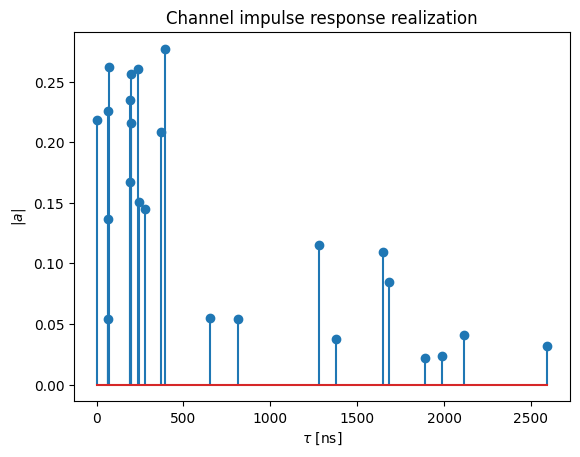

In [282]:
plt.figure()
plt.title("Channel impulse response realization")
plt.stem(tau[0,0,0,:]/1e-9, np.abs(a)[0,0,0,0,0,:,0])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")

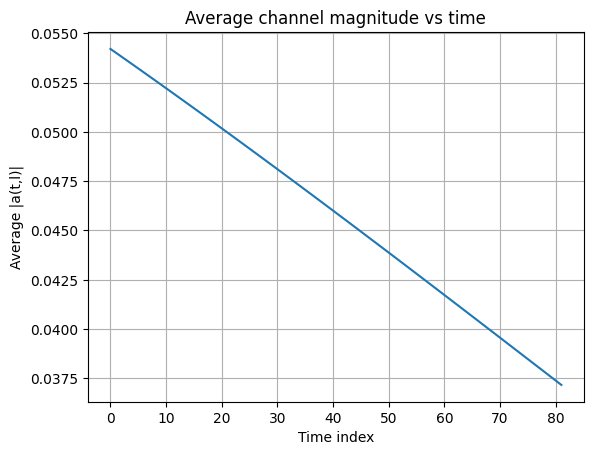

In [288]:
# Remove singleton dimensions
a_s = tf.squeeze(a)    # shape [100, 24, 82]

# Average over batch and taps
a_avg = tf.abs(a_s[0,15,:]) # shape [82]

plt.figure()
plt.plot(a_avg.numpy())
plt.xlabel("Time index")
plt.ylabel("Average |a(t,l)|")
plt.title("Average channel magnitude vs time")
plt.grid(True)
plt.show()


In [231]:
h_time = cir_to_time_channel(bandwidth, a, tau, l_min, l_max, True)

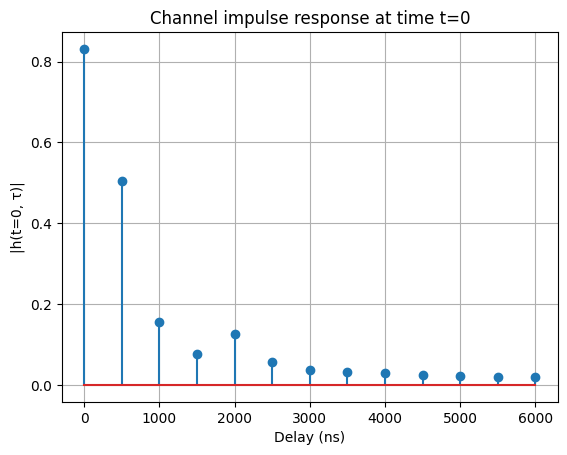

In [237]:
# Extract data
h0 = tf.squeeze(h_time[0, 0, 0, 0, 0, 0, :])  # taps at time t=0
tau0 = tf.squeeze(tau[0, 0, 0, :])           # delays

# Plot impulse response magnitude vs delay
plt.figure()
plt.stem(np.arange(13)*500, tf.abs(tf.squeeze(h_time[0, 0, 0, 0, 0, 0, :])).numpy())
plt.xlabel("Delay (ns)")
plt.ylabel("|h(t=0, τ)|")
plt.title("Channel impulse response at time t=0")
plt.grid(True)
plt.show()

In [232]:
h_time.shape

TensorShape([100, 1, 1, 1, 1, 82, 13])

In [136]:
s_frame.shape

TensorShape([100, 1, 1, 70])

In [146]:
y_c = _apply_channel(s_frame, h_time)

In [147]:
y_c[0,0,0,0]

<tf.Tensor: shape=(), dtype=complex128, numpy=(-0.6523583167367326-0.5763791668970393j)>

In [148]:
h_time[0,0,0,0,0,0,:]

<tf.Tensor: shape=(13,), dtype=complex64, numpy=
array([ 0.8688486 -0.05372537j,  0.33699426+0.29969484j,
       -0.11639235+0.10785881j,  0.0687692 -0.03053768j,
       -0.04793346+0.02042405j,  0.03680795-0.01570852j,
       -0.02988466+0.01284376j,  0.02515839-0.01088861j,
       -0.02172501+0.0094601j ,  0.01911742-0.00836758j,
       -0.01706938+0.00750364j,  0.01541814-0.00680269j,
       -0.01405832+0.00622217j], dtype=complex64)>

In [149]:
s_frame[0,0,0,0]

<tf.Tensor: shape=(), dtype=complex64, numpy=(-0.7071067690849304-0.7071067690849304j)>

In [150]:
s_frame[0,0,0,0]*h_time[0,0,0,0,0,0,0]

<tf.Tensor: shape=(), dtype=complex64, numpy=(-0.6523582935333252-0.5763791799545288j)>

In [126]:
y_c.shape

TensorShape([100, 1, 1, 82])

In [135]:
frame_size + l_tot -1

82

In [167]:
tf.abs(h_time[0,0,0,0,0,5,:] - h_time[0,0,0,0,0,80,:])

<tf.Tensor: shape=(13,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [172]:
# Extract tap vector h
h0 = h_time[0,0,0,0,0,0,:]      # shape [L]

# Extract corresponding signal vector: [x[1], x[0], 0, 0, ...]
x1 = tf.concat([
    s_frame[0,0,0,1::-1],       # [x[1], x[0]]
    tf.zeros_like(h0[2:])       # x[-1], x[-2], ...
], axis=0)

y_manual = tf.cast(tf.reduce_sum(h0 * x1), tf.complex128)

tf.abs(
    y_c[0,0,0,1] -
    y_manual
)



<tf.Tensor: shape=(), dtype=float64, numpy=2.6625103731687493e-08>

In [170]:
h0

<tf.Tensor: shape=(13,), dtype=complex64, numpy=
array([ 0.8688486 -0.05372537j,  0.33699426+0.29969484j,
       -0.11639235+0.10785881j,  0.0687692 -0.03053768j,
       -0.04793346+0.02042405j,  0.03680795-0.01570852j,
       -0.02988466+0.01284376j,  0.02515839-0.01088861j,
       -0.02172501+0.0094601j ,  0.01911742-0.00836758j,
       -0.01706938+0.00750364j,  0.01541814-0.00680269j,
       -0.01405832+0.00622217j], dtype=complex64)>

In [169]:
x0

<tf.Tensor: shape=(13,), dtype=complex64, numpy=
array([-0.70710677-0.70710677j,  0.70710677-0.70710677j,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ], dtype=complex64)>

In [152]:
y_manual.dtype

tf.complex64

In [154]:
y_c[0,0,0,0]

<tf.Tensor: shape=(), dtype=complex128, numpy=(-0.6523583167367326-0.5763791668970393j)>

In [127]:
no

<tf.Tensor: shape=(), dtype=float32, numpy=0.10000000149011612>

In [128]:
y_c = channel_noise(y_c, no) # add noise

In [129]:
y_c.shape

TensorShape([100, 1, 1, 82])

In [ ]:
# def _add_cyclic_prefix(signal, cp_length=6):
#
#     # Take the last cp_length samples from the signal
#     cp = signal[...,signal.shape[-1]- cp_length:]
#     # Prepend the cyclic prefix to the signal
#     signal_with_cp = tf.concat([cp, signal], axis=-1)
#     return signal_with_cp
#
# def prepare_frame_scfde(s,frame_size,cp_length,block_per_frame,block_size):
#
#     batch_size = tf.shape(s)[0]
#     s_cp = tf.reshape(s, [batch_size, block_per_frame, block_size])
#     cp = s_cp[...,s_cp.shape[-1]- cp_length:]
#     signal_with_cp = tf.concat([cp, s_cp], axis=-1)
#     s_frame = tf.reshape(signal_with_cp, [batch_size, 1, 1, frame_size])
#     return s_frame

In [ ]:

# # s_frame = prepare_frame_scfde(s,frame_size,cp_length,block_per_frame,block_size)
# if channel_model == "tdl":
#     a, tau = tdl(batch_size,  num_time_steps, bandwidth)
#     h_time = cir_to_time_channel(bandwidth, a, tau, l_min,
#                                  l_max, True)
#     y_c = _apply_channel(s_frame, h_time) # apply channel
# else:
#     y_c = s_frame
#     h_time = tf.ones([batch_size, 1, 1, 1, 1, y_c.shape[-1], 1], dtype=tf.complex64)